<a href="https://colab.research.google.com/github/sainisatish/DeepLearningFromScratch/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**"As a beginner in deep learning, I have been exploring various architectural designs and patterns. I started with a basic CNN architecture and have since expanded my knowledge by studying different pre-trained models, such as VGG16, VGG19, and ResNet50."**

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

# Visualize Data

In [ ]:
"Plot data distributions of the classes and fetch image path list"
def visualize_data(path,show_chart=True):
    classes = {}
    for category in os.listdir(path):
        images =  os.listdir(path+"/"+category)
        paths = [ (path+"/"+category+"/"+img_path) for img_path in images ]
        classes[category] =  len(images)
        
    if show_chart:
        
        class_name = list(classes.keys())
        values = list(classes.values())
        explode = [0.1,0.4,0.1,0.1,0.1,0.1,0.1]
        plt.pie(values,labels=class_name,explode=explode,autopct='%1.1f%%')
        font = {'family': 'serif',
                'color':  'darkred',
                'weight': 'normal',
                'size': 16,
                }
        plt.title(class_name,fontdict=font)
        
    
    
    return paths

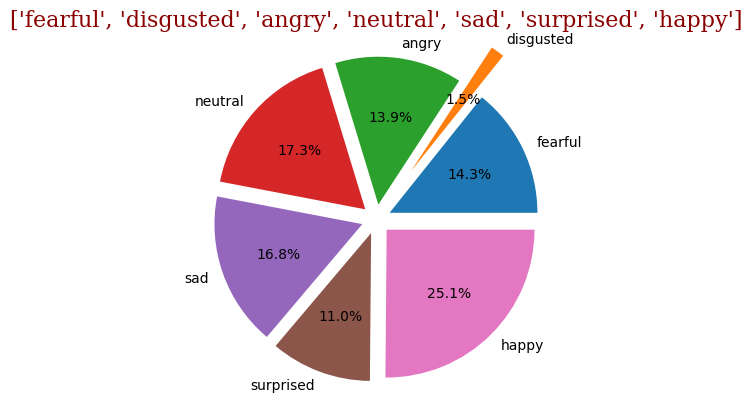

In [ ]:
train_data_path = "/kaggle/input/emotion-detection-fer/train/"
train_paths = visualize_data(train_data_path)

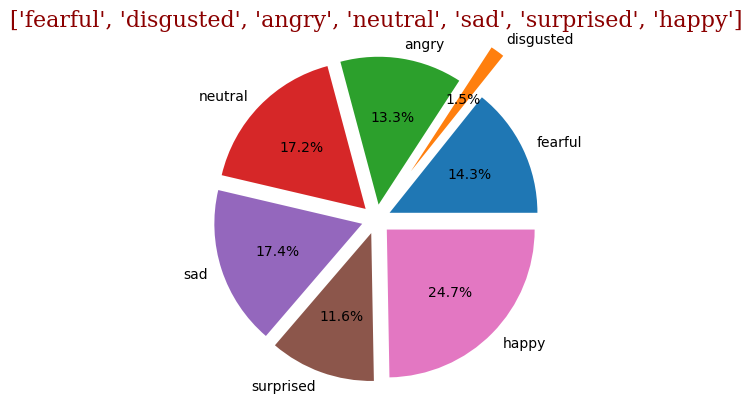

In [ ]:
test_data_path= "/kaggle/input/emotion-detection-fer/test/"
test_paths=visualize_data(test_data_path)

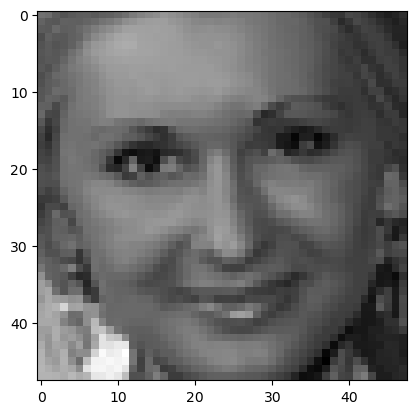

In [ ]:
#train_paths is the list of paths of the images , which is fetch using function visualize data .
img = plt.imread(train_paths[0])
plt.imshow(img,cmap="gray")
plt.show()

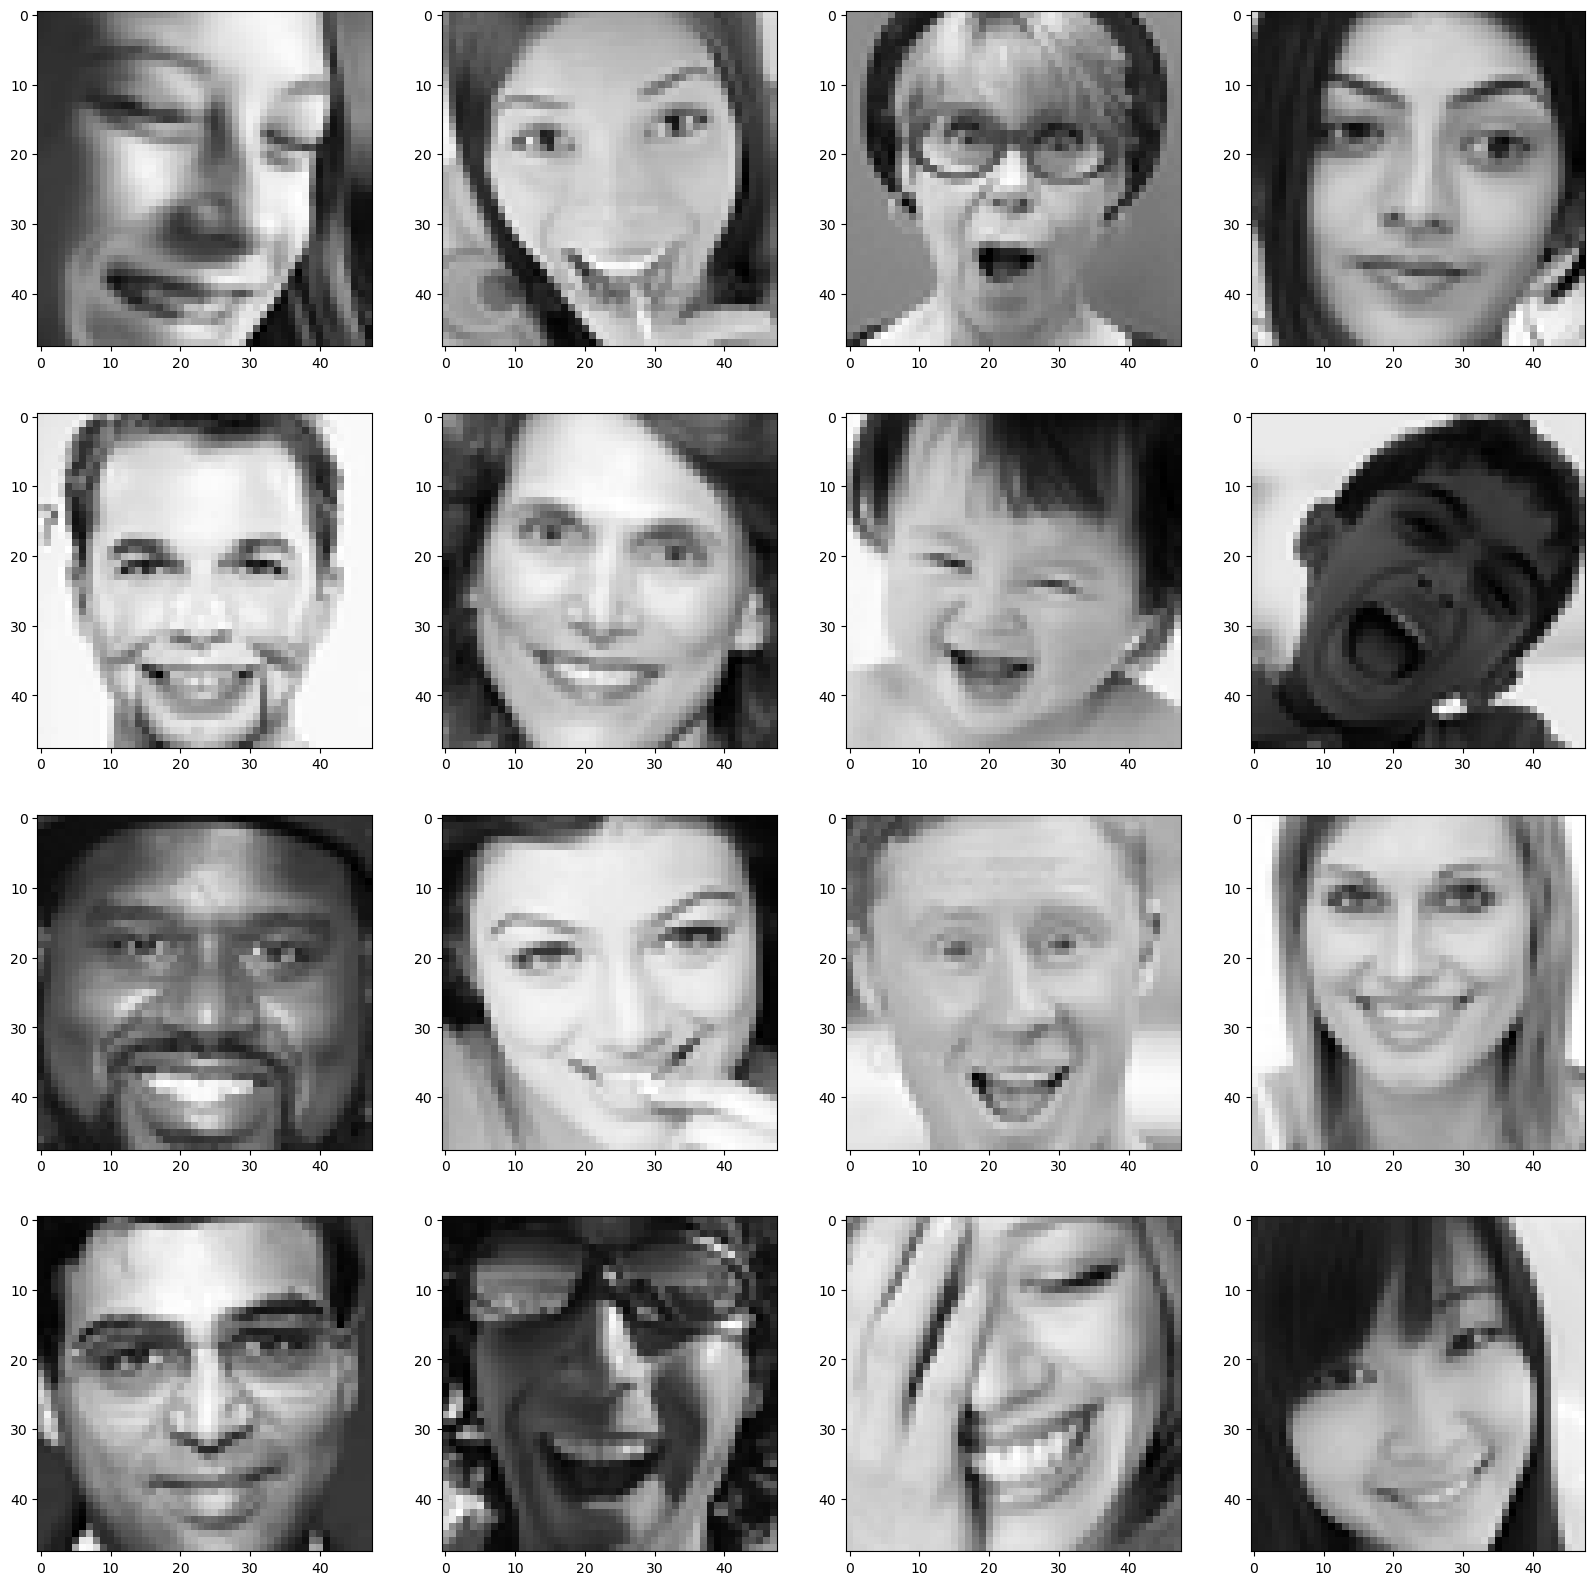

In [ ]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    img = plt.imread(random.choice(train_paths))
    plt.imshow(img,cmap="gray")
plt.show()

In [ ]:
print(f"image shape : {img.shape}")

image shape : (48, 48)


> **Dataset contain grayscale images and the shape of image is  (48*48).**

> **Dataset is imbalanced, class "Disgusted" have very few images( only 1.5% out of 100%) in train as       well as test dataset.**

> **Class "Disgusted" share some attributes of class "Angry" ,So I am merging this class to angry           class.**

# Copy dataset to the working/output directory
> In Input directory dataset is read only

In [ ]:
# Below command will copy the dataset to output directory 
# !cp -r /kaggle/input/emotion-detection-fer /kaggle/working/

In [ ]:
# In Train Data 
# Uncomment below code to move images from class "disgusted" to class "Angry"

"""
source_dir = "/kaggle/working/emotion-detection-fer/train/disgusted"
target_dir = "/kaggle/working/emotion-detection-fer/train/angry/"
files = os.listdir(source_dir)
for img in in files:
    shutil.move(os.path.join(source_dir+img),target_dir+str(img))
"""

# In Test Data

"""source_dir = "/kaggle/working/emotion-detection-fer/test/disgusted/"
target_dir = "/kaggle/working/emotion-detection-fer/test/angry/"
files = os.listdir(source_dir)
for img in files:
    shutil.move(os.path.join(source_dir+img),target_dir+str(img))
"""



In [ ]:
#delete the disgusted class 
#os.rmdir("/kaggle/working/emotion-detection-fer/train/disgusted")
#os.rmdir("/kaggle/working/emotion-detection-fer/test/disgusted")

In [ ]:
train_data_path="/kaggle/working/emotion-detection-fer/train"


train_data = image_dataset_from_directory(train_data_path,
                                          batch_size=32,
                                          image_size=(48,48),
                                          validation_split=0.2,
                                          subset="training",
                                          seed=123,
                                          shuffle=True,
                                          color_mode="grayscale")

val_data   = image_dataset_from_directory(train_data_path,
                                          batch_size=32,
                                          image_size=(48,48),
                                          validation_split=0.2,
                                          subset="validation",
                                          seed=123,
                                          shuffle=True,
                                          color_mode="grayscale")

Found 28273 files belonging to 6 classes.
Using 22619 files for training.
Found 28273 files belonging to 6 classes.
Using 5654 files for validation.


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.Rescaling(1./255)
    ])


In [ ]:
train_data = train_data.map(lambda x,y: (data_augmentation(x),y))

In [ ]:
val_data = val_data.map(lambda x,y: (Rescaling(1./255)(x),y))

In [ ]:
test_data = test_data.map(lambda x,y: (Rescaling(1./255)(x),y))

In [ ]:
test_data_path ="/kaggle/working/emotion-detection-fer/test"
test_data = image_dataset_from_directory(test_data_path,
                                          batch_size=32,
                                          image_size=(48,48),
                                          color_mode="grayscale")

Found 7067 files belonging to 6 classes.


In [ ]:
class_names = train_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i],cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

AttributeError: 'MapDataset' object has no attribute 'class_names'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data   = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_data:
    print(f"Image Shape : {image_batch.shape}, Label Shape: {labels_batch.shape}")
    break

Image Shape : (32, 48, 48, 1), Label Shape: (32,)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Model - Basic CNN Model
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

VGG Model arc

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Rescaling,AveragePooling2D
from tensorflow.keras.constraints import unit_norm

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def makeVGG6():
    
    def conv_block(n_layers,n_filters):
        
        for n in range(n_layers):
            
            model.add(Conv2D(n_filters,(3,3),strides=(1,1),padding="same",activation="relu",kernel_initializer="he_normal",))
        
        model.add(AveragePooling2D())
                  
        
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),padding="same",activation="relu",input_shape=(48,48,1),kernel_initializer="he_normal"))
    
    conv_block(1,128)
    conv_block(2,128)
    model.add(Flatten())
    model.add(Dense(2048,activation="relu",kernel_initializer="he_normal"))
    model.add(Dropout(0.50))
    model.add(Dense(6,activation="softmax",kernel_initializer="he_normal"))
    optmizer = tf.keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001)
    model.compile(optimizer=optmizer,loss="SparseCategoricalCrossentropy",metrics=["accuracy"])
   
    return model
    
    

In [ ]:
def makeVGG6v2():
    
    def conv_block(n_layers,n_filters):
        
        for n in range(n_layers):
            
            model.add(Conv2D(n_filters,(3,3),strides=(1,1),padding="same",activation="relu",kernel_initializer="he_normal",))
        
        model.add(AveragePooling2D())
                  
        
    model = Sequential()
    model.add(Conv2D(32,(3,3),strides=(1,1),padding="same",activation="relu",input_shape=(48,48,1),kernel_initializer="he_normal"))
    
    conv_block(1,64)
    conv_block(2,128)
    model.add(Flatten())
    model.add(Dense(2048,activation="relu",kernel_initializer="he_normal"))
    model.add(Dropout(0.50))
    model.add(Dense(6,activation="softmax",kernel_initializer="he_normal"))
    optmizer = tf.keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001)
    model.compile(optimizer=optmizer,loss="SparseCategoricalCrossentropy",metrics=["accuracy"])
   
    return model
    

In [ ]:
vgg6 = makeVGG6()

In [ ]:
vgg6v2 = makeVGG6v2()

In [ ]:
vgg6v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 average_pooling2d_1 (Averag  (None, 12, 12, 128)      0         
 ePooling2D)                                            

In [ ]:
callbacks = keras.callbacks.ModelCheckpoint(save_best_only=True,filepath="optimized_modelv2.keras",monitor="val_loss")

In [ ]:
history = vgg6v2.fit(train_data,epochs=20,validation_data=val_data,callbacks=callbacks)

Epoch 1/20
707/707 [==============================] - 31s 41ms/step - loss: 1.8194 - accuracy: 0.2538 - val_loss: 1.7470 - val_accuracy: 0.2565
Epoch 2/20
707/707 [==============================] - 30s 42ms/step - loss: 1.7264 - accuracy: 0.2696 - val_loss: 1.6731 - val_accuracy: 0.3024
Epoch 3/20
707/707 [==============================] - 30s 42ms/step - loss: 1.6698 - accuracy: 0.2986 - val_loss: 1.6420 - val_accuracy: 0.3159
Epoch 4/20
707/707 [==============================] - 30s 42ms/step - loss: 1.6191 - accuracy: 0.3388 - val_loss: 1.5263 - val_accuracy: 0.3861
Epoch 5/20
707/707 [==============================] - 29s 41ms/step - loss: 1.5245 - accuracy: 0.3896 - val_loss: 1.4319 - val_accuracy: 0.4319
Epoch 6/20
707/707 [==============================] - 29s 41ms/step - loss: 1.4358 - accuracy: 0.4343 - val_loss: 1.3483 - val_accuracy: 0.4738
Epoch 7/20
707/707 [==============================] - 29s 42ms/step - loss: 1.3759 - accuracy: 0.4609 - val_loss: 1.2888 - val_accuracy:

End Block


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Model 1
num_classes = 6
inputs = keras.Input(shape=(48,48,1))
normalize = layers.Rescaling(1./255)(inputs)


conv1 = layers.Conv2D(32,3,activation="relu")(normalize)
conv11 = layers.Conv2D(64,5,activation="relu")(conv1)
pool1 = layers.MaxPooling2D()(conv11)
drop1 = layers.Dropout(0.25)(pool1)

conv2 = layers.Conv2D(128,5,activation="relu")(drop1)
conv22 = layers.Conv2D(256,5,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(conv2)
batch2 = layers.BatchNormalization()(conv22)
pool2 = layers.MaxPooling2D()(batch2)
drop2 = layers.Dropout(0.50)(pool2)

conv3 = layers.Conv2D(512,5,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(drop2)
batch3 = layers.BatchNormalization()(conv3)
pool3 = layers.MaxPooling2D()(batch3)
drop3 = layers.Dropout(0.50)(pool3)

flatten = layers.Flatten()(drop3)
dense1 = layers.Dense(128,activation="relu")(flatten)
dropout= layers.Dropout(0.5)(dense1)

outputs = layers.Dense(num_classes,activation="softmax")(dropout)

Model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                             

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
Model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

In [ ]:
callbacks = keras.callbacks.ModelCheckpoint(save_best_only=True,filepath="opt1_basic_model.keras",monitor="val_loss")

In [ ]:
history = Model.fit(train_data,epochs=30,validation_data=val_data,callbacks=callbacks)

Epoch 1/30


2023-03-18 03:57:04.748387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


707/707 [==============================] - 22s 18ms/step - loss: 6.6940 - sparse_categorical_accuracy: 0.2036 - val_loss: 6.0370 - val_sparse_categorical_accuracy: 0.2002
Epoch 2/30
707/707 [==============================] - 11s 15ms/step - loss: 4.9837 - sparse_categorical_accuracy: 0.2118 - val_loss: 5.6192 - val_sparse_categorical_accuracy: 0.1965
Epoch 3/30
707/707 [==============================] - 11s 15ms/step - loss: 4.0849 - sparse_categorical_accuracy: 0.2258 - val_loss: 3.7817 - val_sparse_categorical_accuracy: 0.2457
Epoch 4/30
707/707 [==============================] - 11s 15ms/step - loss: 3.4233 - sparse_categorical_accuracy: 0.2398 - val_loss: 3.1926 - val_sparse_categorical_accuracy: 0.2140
Epoch 5/30
707/707 [==============================] - 11s 15ms/step - loss: 2.9169 - sparse_categorical_accuracy: 0.2659 - val_loss: 2.7382 - val_sparse_categorical_accuracy: 0.2849
Epoch 6/30
707/707 [==============================] - 11s 15ms/step - loss: 2.5337 - sparse_categoric

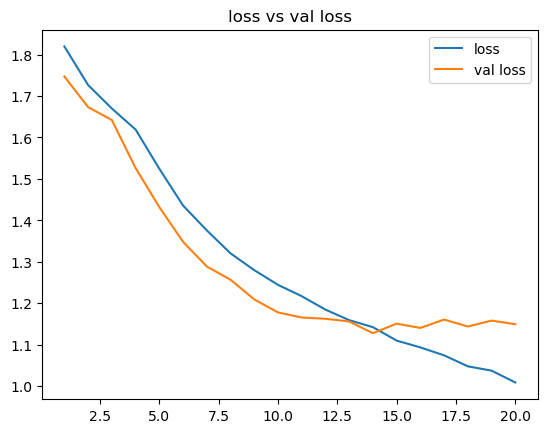

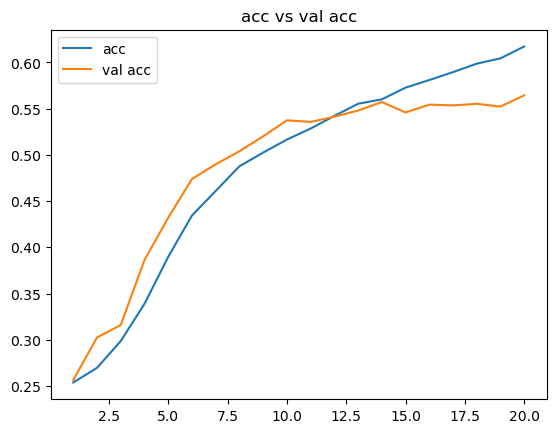

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]


epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,label="loss")
plt.plot(epochs,val_loss,label="val loss")
plt.legend()
plt.title("loss vs val loss")
plt.show()

plt.plot(epochs,acc,label="acc")
plt.plot(epochs,val_acc,label="val acc")
plt.legend()
plt.title("acc vs val acc")
plt.show()



In [ ]:
import pandas as pd
Model_performance = pd.DataFrame(history.history)
Model_performance.to_csv("optimized_model2.csv")

In [ ]:
vgg6.evaluate(train_data)

707/707 [==============================] - 23s 32ms/step - loss: 0.9660 - accuracy: 0.6392


[0.9660438895225525, 0.6391529440879822]

In [ ]:
vgg6.evaluate(test_data) # without rescaling data 

221/221 [==============================] - 2s 7ms/step - loss: 365.6776 - accuracy: 0.2168


[365.6776428222656, 0.21678222715854645]

In [ ]:
vgg6.evaluate(test_data)# With rescaling data

221/221 [==============================] - 2s 7ms/step - loss: 1.1609 - accuracy: 0.5468


[1.1609241962432861, 0.5467666387557983]

In [ ]:
vgg6.evaluate(val_data)

177/177 [==============================] - 1s 6ms/step - loss: 1.1506 - accuracy: 0.5492


[1.1506404876708984, 0.5491687059402466]

Model performance result : poor

# Applying Data Augmentation on Training Data

In [ ]:
# Model 2
num_classes = 6
inputs = keras.Input(shape=(48,48,1))
normalize = layers.Rescaling(1./255)(inputs)
conv1 = layers.Conv2D(32,3,activation="relu")(inputs)
pool1 = layers.MaxPooling2D()(conv1)
conv2 = layers.Conv2D(64,3,activation="relu")(pool1)
pool2 = layers.MaxPooling2D()(conv2)
conv3 = layers.Conv2D(128,3,activation="relu")(pool2)
flatten = layers.Flatten()(conv3)
dense1 = layers.Dense(128,activation="relu")(flatten)
dropout= layers.Dropout(0.5)(dense1)
outputs = layers.Dense(num_classes,activation="softmax")(dropout)

Model_2 = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    ])

# Performing Data Augmentation on train data
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
#Rescaling validation data and test data if required else adding this layer in the model
"""train_data = val_data.map(lambda x,y: (layers.Rescaling(1./255)(x),y) )
val_data   = val_data.map(lambda x,y: (layers.Rescaling(1./255)(x),y) )
test_data  = test_data.map(lambda x,y:(layers.Rescaling(1./255)(x),y) )"""

**Performing some changes in the model structure **

In [ ]:
Model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856 

In [ ]:
Model_2.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
callbacks= keras.callbacks.ModelCheckpoint(filepath="basic_model.keras",save_best_only=True,monitor="val_loss")

In [ ]:
history = Model_2.fit(train_data,epochs=30,validation_data=val_data,callbacks=callbacks)

Epoch 1/30
707/707 [==============================] - 31s 32ms/step - loss: 1.8524 - accuracy: 0.2531 - val_loss: 1.7554 - val_accuracy: 0.2542
Epoch 2/30
707/707 [==============================] - 20s 28ms/step - loss: 1.7588 - accuracy: 0.2581 - val_loss: 1.7538 - val_accuracy: 0.2542
Epoch 3/30
707/707 [==============================] - 20s 28ms/step - loss: 1.7576 - accuracy: 0.2593 - val_loss: 1.7569 - val_accuracy: 0.2511
Epoch 4/30
707/707 [==============================] - 19s 27ms/step - loss: 1.7494 - accuracy: 0.2604 - val_loss: 1.7147 - val_accuracy: 0.2754
Epoch 5/30
707/707 [==============================] - 20s 29ms/step - loss: 1.7164 - accuracy: 0.2748 - val_loss: 1.7201 - val_accuracy: 0.2600
Epoch 6/30
707/707 [==============================] - 20s 28ms/step - loss: 1.6883 - accuracy: 0.2940 - val_loss: 1.6524 - val_accuracy: 0.3074
Epoch 7/30
707/707 [==============================] - 20s 28ms/step - loss: 1.6704 - accuracy: 0.3055 - val_loss: 1.6448 - val_accuracy:

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc  = history.history["accuracy"] 
val_acc = history.history["val_accuracy"]

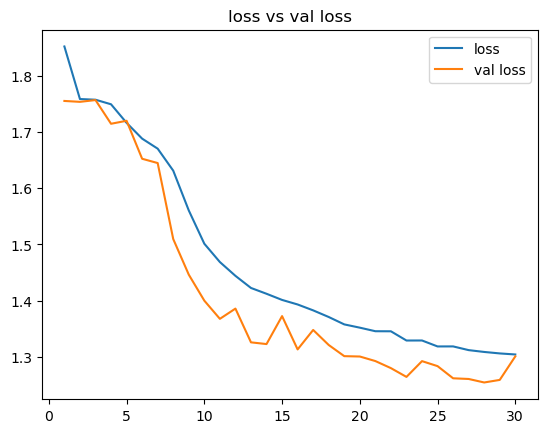

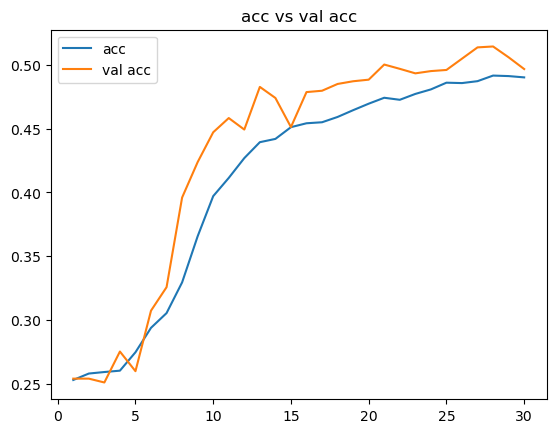

In [ ]:
epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,label="loss")
plt.plot(epochs,val_loss,label="val loss")
plt.legend()
plt.title("loss vs val loss")
plt.show()

plt.plot(epochs,acc,label="acc")
plt.plot(epochs,val_acc,label="val acc")
plt.legend()
plt.title("acc vs val acc")
plt.show()

In [ ]:
import pandas as pd
Model_performance = pd.DataFrame(history.history)
Model_performance.to_csv("30_epoch_data_aug.csv")

In [ ]:
Model_2.evaluate(test_data)

# Checking activation maps to visualize it's learning
> Visualizing intermediate layer output

> Visualizing filter output

> Visualizing heat maps

In [ ]:
layer_outputs=[]
layer_names= []

for layer in vgg6.layers:
        if isinstance(layer,(layers.Conv2D,layers.MaxPooling2D,layers.AveragePooling2D)): 
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

In [ ]:
activation_model = keras.Model(inputs=vgg6.input,outputs=layer_outputs)

In [ ]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 128)      0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                             

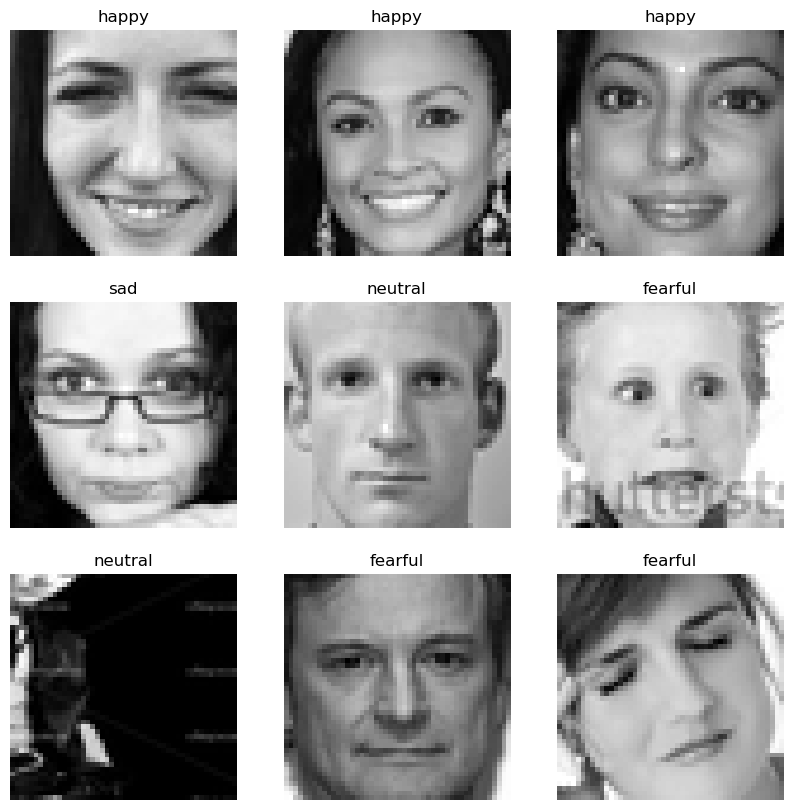

In [ ]:
#Visualize test data
class_names= test_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(images[i],cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

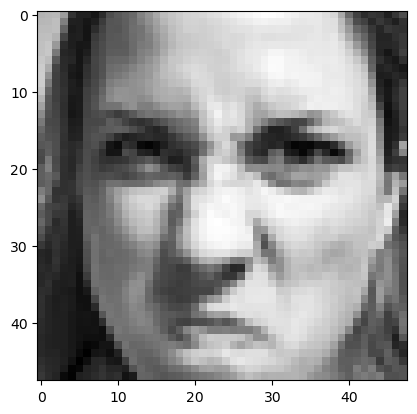

'angry'

In [ ]:
class_names=test_data.class_names
batch = test_data.take(1)  # take a batch of images 
img, label = batch.get_single_element() 
sample_image = img[2]
plt.imshow(sample_image,cmap="gray")
plt.show()
sample_image= np.expand_dims(sample_image,axis=0)
class_names[label[2].numpy()]

In [ ]:
x = vgg6.predict(sample_image)
class_names[x[0].argmax()]


1/1 [==============================] - 0s 25ms/step


'sad'

In [ ]:
activations = activation_model.predict(sample_image)

1/1 [==============================] - 0s 25ms/step


In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)


(1, 48, 48, 64)


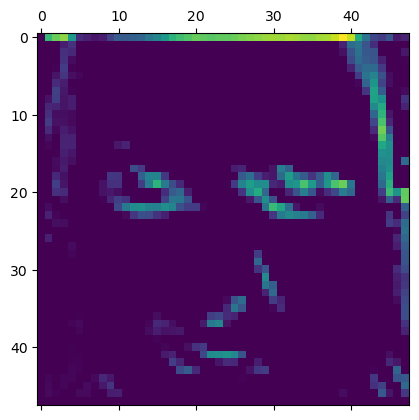

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

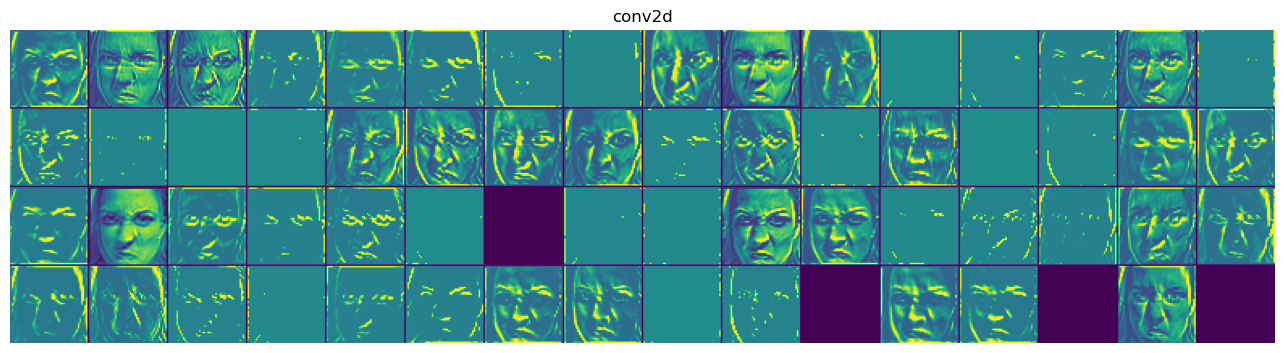

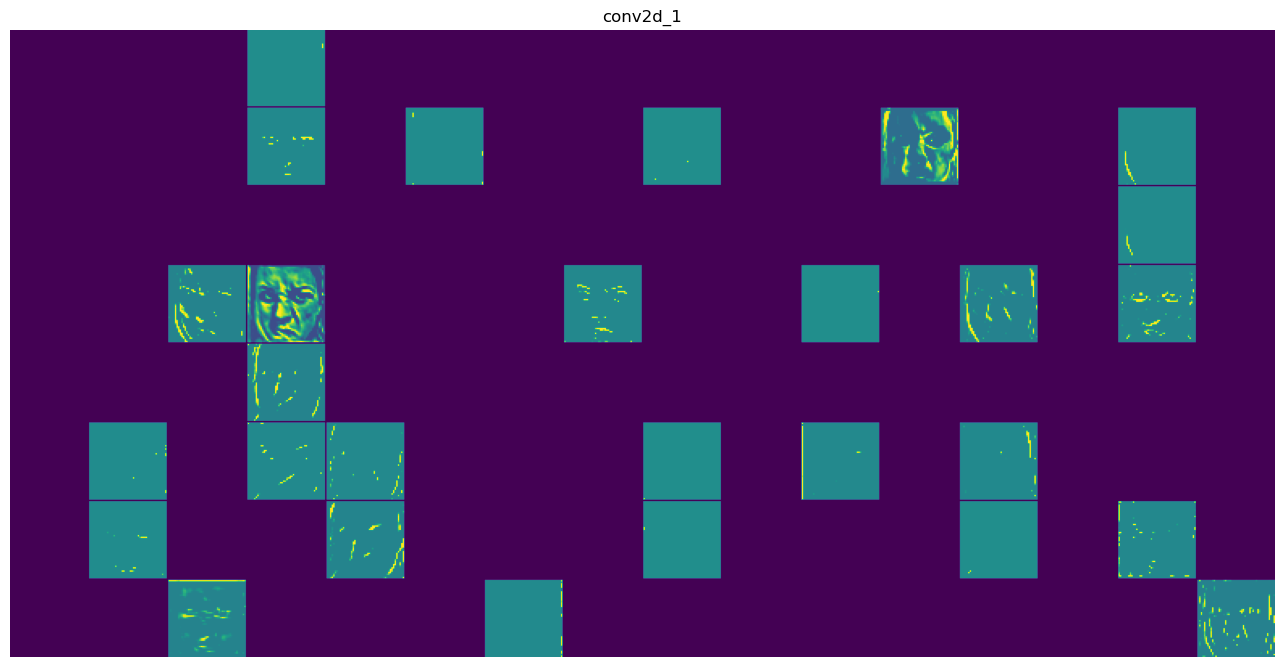

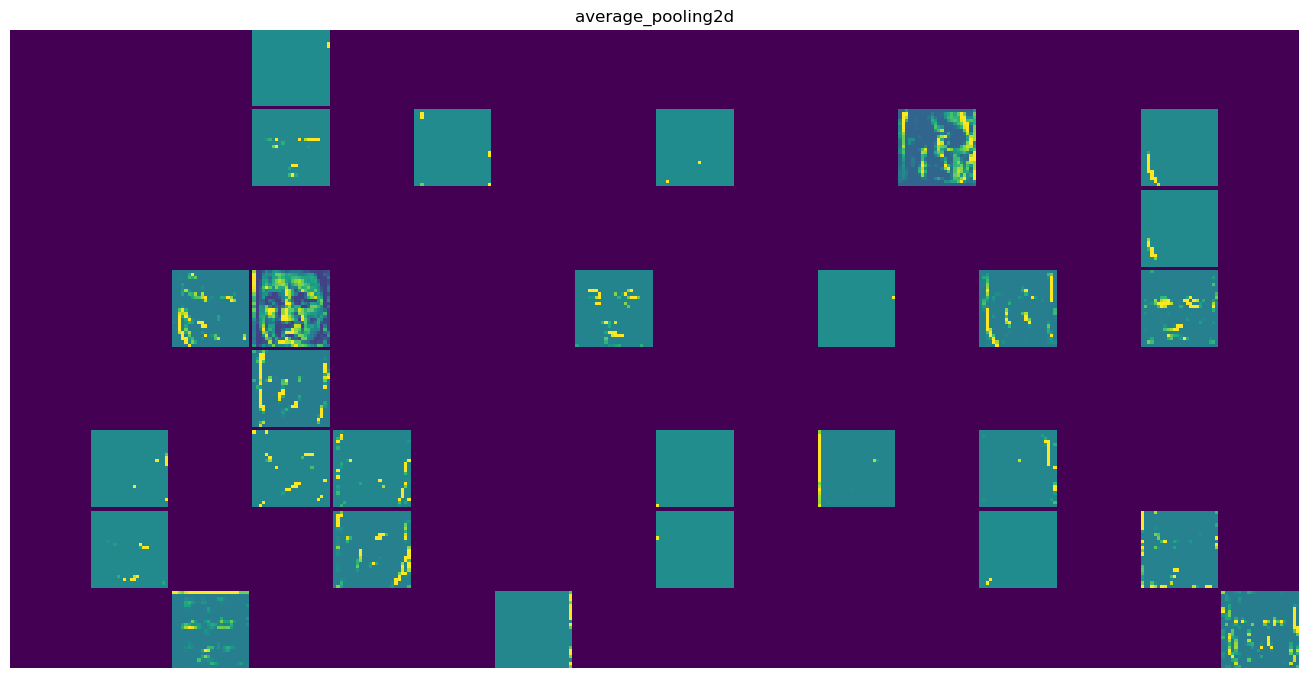

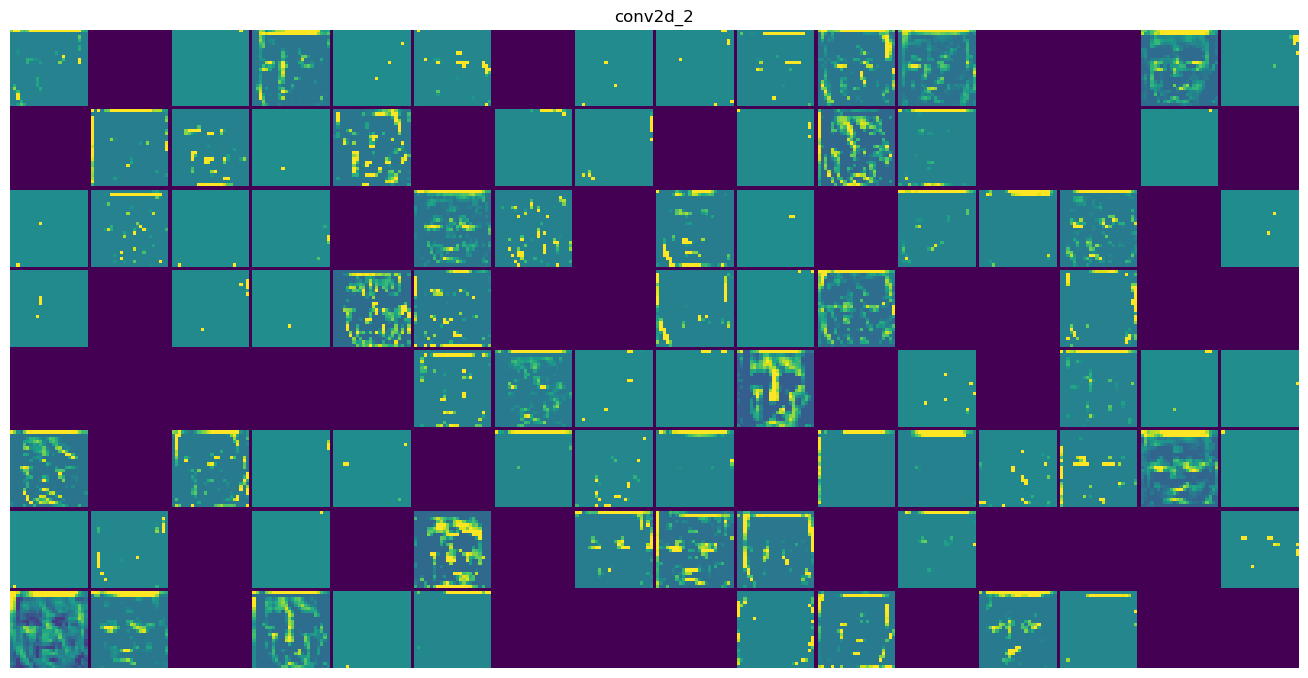

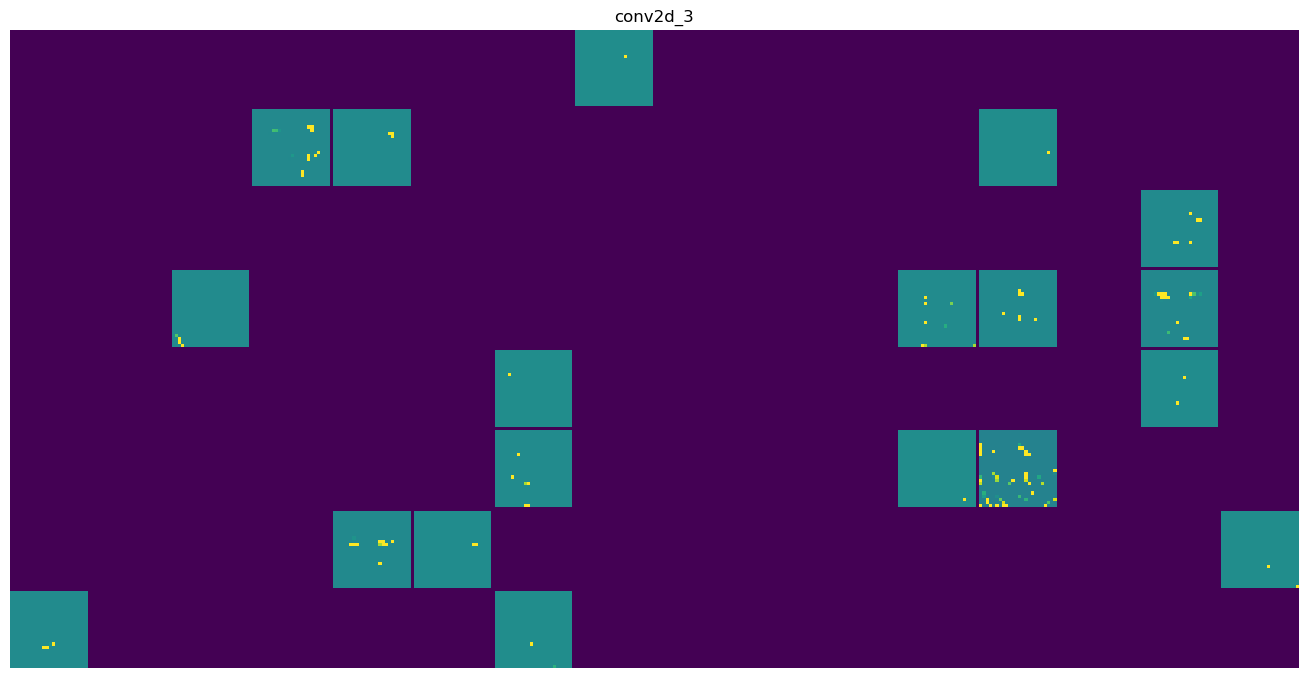

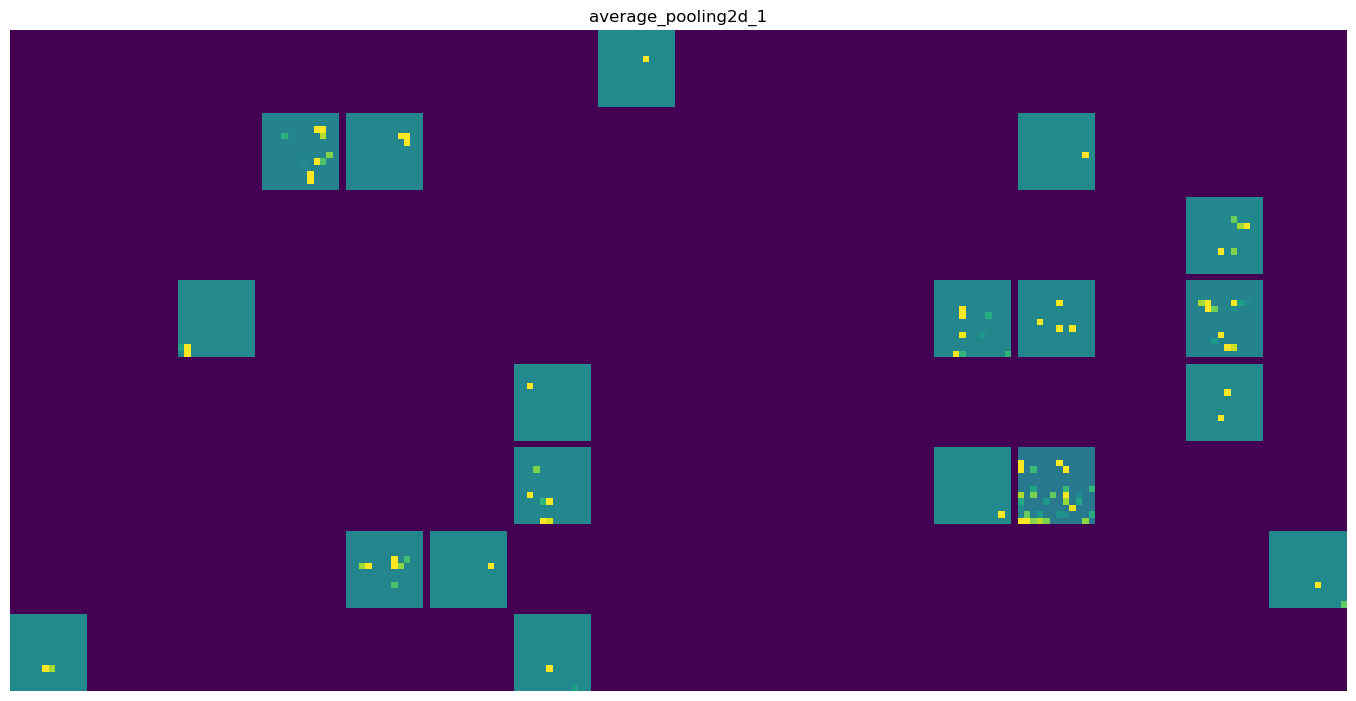

In [ ]:
images_per_row = 16 
for layer_name, layer_activation in zip(layer_names, activations):         
    n_features = layer_activation.shape[-1]                                
    size = layer_activation.shape[1]                                       
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,                      
                             images_per_row * (size + 1) - 1))             
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:                                   
                channel_image -= channel_image.mean()                      
                channel_image /= channel_image.std()                       
                channel_image *= 64                                        
                channel_image += 128                                       
            channel_image = np.clip(channel_image, 0, 255).astype("uint8") 
            display_grid[
                col * (size + 1): (col + 1) * size + col,                  
                row * (size + 1) : (row + 1) * size + row] = channel_image 
    scale = 1. / size                                                      
    plt.figure(figsize=(scale * display_grid.shape[1],                     
                        scale * display_grid.shape[0]))                    
    plt.title(layer_name)                                                  
    plt.grid(False)                                                        
    plt.axis("off")                                                        
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

# Review on Intermediate output layer

> Layer : Conv2D 
  "  Detecting edges in layer "

> Layer : Conv2D_1
  " Detecting pattern but there is only few filters which is activating on face(eyes,lips,eyebrows) " 

> Layer : Conv2D_2
  " Detecting pattern but it is not deep to detect required features. 
  
  For emotions detection , each emotions show unqiue characterstics(as per article : The Seven Universal Emotions We Wear On Our Face(www.cbc.ca).
  
  Happy : Cheeks raised, lip corners raised diagonally
  
  Anger : Eyebrows pulled down, upper eyelids pulled up, lower eyelids pulled up, margins of lips                 rolled in, lips may be tightened.
  
  Fear  : Eyebrows pulled up and together, upper eyelids pulled up, mouth stretched.
  
  Sad   : Inner corners of eyebrows raised, eyelids loose, lip corners pulled down.
  
  Surprised : Entire eyebrow pulled up, eyelids pulled up, mouth hangs open, pupils dilated.
  
  Neutral : Normal face features
  
  
  Based on this our model need to learn the required patterns like eyes ,lips, mouth, eyebrows.
  
  We need a model which can detect these pattern.
  
  
  
  

**Making Prediction**

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
        
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = np.expand_dims(images[i],axis=0)
        x = Model.predict(img)
        x = classes[x.argmax()]
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[ labels[i]]+" pred:"+str(x))
        plt.axis("off")

**Applying Transfer Learning**

# >> > > > > > > > > > > > > > > > > > > > > > > > > 
# ResNet50
# >> > > > > > > > > > > > > > > > > > > > > > > > > 


In [ ]:
#ResNet model require 3 channel image but we have single channel , so we are loading the image in 3 channel mode
train_data_path="/kaggle/working/emotion-detection-fer/train"
train_data = image_dataset_from_directory(train_data_path,
                                          batch_size=32,
                                          image_size=(48,48),
                                          validation_split=0.3,
                                          subset="training",
                                          seed=123,
                                          color_mode="rgb")

val_data   = image_dataset_from_directory(train_data_path,
                                          batch_size=32,
                                          image_size=(48,48),
                                          validation_split=0.3,
                                          subset="validation",
                                          seed=123,
                                          color_mode="rgb")
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data   = val_data.cache().prefetch(buffer_size=AUTOTUNE)


Found 28273 files belonging to 6 classes.
Using 19792 files for training.
Found 28273 files belonging to 6 classes.
Using 8481 files for validation.


In [ ]:
train_data.element_spec

In [ ]:
#Model 2
base_model = tf.keras.applications.resnet.ResNet50(weights="None",include_top=False,input_shape=(48,48,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

In [ ]:
base_model.trainable=False

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [ ]:
#Model Transfer Learning: ResNet50
num_classes =6
Inputs = keras.Input(shape=(48,48,3))
data_aug = data_augmentation(Inputs)
process_input = keras.applications.resnet.preprocess_input(data_aug)
resnet_base_model = base_model(process_input)
flatten = layers.Flatten()(resnet_base_model)
dense1 = layers.Dense(256)(flatten)
dropout1 = layers.Dropout(0.5)(dense1)
outputs= layers.Dense(num_classes,activation="softmax")(dropout1)
ResNet_Model = keras.Model(inputs=Inputs,outputs=outputs)

In [ ]:
ResNet_Model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 48, 48, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 48, 48, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0   

In [ ]:
ResNet_Model.compile(optimizer="adam",loss="SparseCategoricalCrossentropy",metrics=["accuracy"])

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

#earlystop = EarlyStopping(monitor="val_accuracy")

In [ ]:
callbacks=keras.callbacks.ModelCheckpoint(save_best_only="True",filepath="ResNet50.keras",monitor="val_loss")

In [ ]:
history = ResNet_Model.fit(train_data,epochs=50,validation_data = val_data,callbacks=callbacks)

Epoch 1/50
619/619 [==============================] - 108s 155ms/step - loss: 9.9644 - accuracy: 0.2993 - val_loss: 1.9734 - val_accuracy: 0.4012
Epoch 2/50
619/619 [==============================] - 93s 151ms/step - loss: 1.7560 - accuracy: 0.3707 - val_loss: 1.5105 - val_accuracy: 0.4106
Epoch 3/50
619/619 [==============================] - 93s 150ms/step - loss: 1.6136 - accuracy: 0.3794 - val_loss: 1.5350 - val_accuracy: 0.4161
Epoch 4/50
619/619 [==============================] - 92s 149ms/step - loss: 1.6544 - accuracy: 0.3727 - val_loss: 1.8125 - val_accuracy: 0.3737
Epoch 5/50
619/619 [==============================] - 92s 149ms/step - loss: 1.7493 - accuracy: 0.3614 - val_loss: 1.5731 - val_accuracy: 0.4058
Epoch 6/50
619/619 [==============================] - 90s 145ms/step - loss: 1.8231 - accuracy: 0.3595 - val_loss: 1.6177 - val_accuracy: 0.3857
Epoch 7/50
619/619 [==============================] - 88s 143ms/step - loss: 1.8641 - accuracy: 0.3627 - val_loss: 1.6547 - val_a

KeyboardInterrupt: 

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc  = history.history["accuracy"] 
val_acc = history.history["val_accuracy"]

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,label="loss")
plt.plot(epochs,val_loss,label="val loss")
plt.legend()
plt.title("loss vs val loss")
plt.show()

plt.plot(epochs,acc,label="acc")
plt.plot(epochs,val_acc,label="val acc")
plt.legend()
plt.title("acc vs val acc")
plt.show()

In [ ]:
test_data_path = "/kaggle/input/emotion-detection-fer/test"
test_data = image_dataset_from_directory(test_data_path,batch_size=32,image_size=(48,48),color_mode="rgb")  

In [ ]:
class_names = test_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
        
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = np.expand_dims(images[i],axis=0)
        x = ResNet_Model.predict(img)
        x = classes[x.argmax()]
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[ labels[i]]+" pred:"+str(x))
        plt.axis("off")

# >> > > > > > > > > > > > > > > > > > > > > > > > > 
# Working with VGG16
# >> > > > > > > > > > > > > > > > > > > > > > > > > 


In [ ]:
#Loading input data pipeline
train_data_path="/kaggle/working/emotion-detection-fer/train"
train_data = image_dataset_from_directory(train_data_path,batch_size=32,image_size=(48,48),validation_split=0.2,subset="training",seed=123,color_mode="rgb")
val_data   = image_dataset_from_directory(train_data_path,batch_size=32,image_size=(48,48),validation_split=0.2,subset="validation",seed=123,color_mode="rgb")
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data   = val_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 28273 files belonging to 6 classes.
Using 22619 files for training.
Found 28273 files belonging to 6 classes.
Using 5654 files for validation.


In [ ]:
#Preparing data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [ ]:
#Model Transfer Learning: VGG16

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False,weights="imagenet",input_shape=(48,48,3))

In [ ]:
#Model 

Input = keras.Input(shape=(48,48,3))
data_aug = data_augmentation(Input)
process_input = tf.keras.applications.vgg16.preprocess_input(data_aug)
base_model = vgg16_model(process_input)
flatten = layers.Flatten()(base_model)
dense1 = layers.Dense(128,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense1)
Output = layers.Dense(6,activation='softmax')(dropout)

Model = keras.Model(inputs=Input,outputs=Output)

In [ ]:
#Freezing the vgg16 base model so it can only work as a feature extractor
vgg16_model.trainable=False

In [ ]:
Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                             

In [ ]:
Model.compile(optimizer="rmsprop",loss="SparseCategoricalCrossentropy",metrics=['Accuracy'])

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="vgg16_model.keras",save_best_only=True,monitor="val_loss")]

In [ ]:
history = Model.fit(train_data,epochs =100,validation_data = val_data,callbacks=callbacks)

Epoch 1/100
707/707 [==============================] - 104s 134ms/step - loss: 1.7782 - Accuracy: 0.2465 - val_loss: 1.7502 - val_Accuracy: 0.2503
Epoch 2/100
707/707 [==============================] - 92s 130ms/step - loss: 1.7467 - Accuracy: 0.2542 - val_loss: 1.7400 - val_Accuracy: 0.2508
Epoch 3/100
707/707 [==============================] - 91s 129ms/step - loss: 1.7384 - Accuracy: 0.2567 - val_loss: 1.7311 - val_Accuracy: 0.2522
Epoch 4/100
707/707 [==============================] - 91s 129ms/step - loss: 1.7345 - Accuracy: 0.2595 - val_loss: 1.7274 - val_Accuracy: 0.2542
Epoch 5/100
707/707 [==============================] - 91s 129ms/step - loss: 1.7321 - Accuracy: 0.2577 - val_loss: 1.7265 - val_Accuracy: 0.2552
Epoch 6/100
707/707 [==============================] - 90s 128ms/step - loss: 1.7294 - Accuracy: 0.2593 - val_loss: 1.7211 - val_Accuracy: 0.2536
Epoch 7/100
707/707 [==============================] - 91s 128ms/step - loss: 1.7269 - Accuracy: 0.2601 - val_loss: 1.7156 

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc  = history.history["Accuracy"] 
val_acc = history.history["val_Accuracy"]

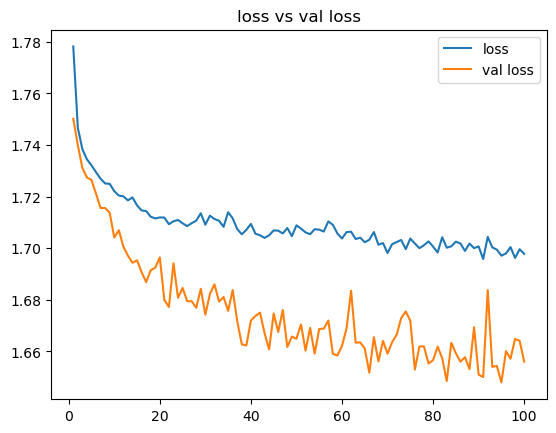

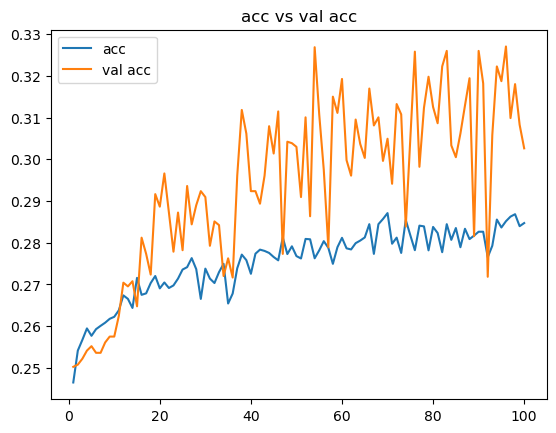

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,label="loss")
plt.plot(epochs,val_loss,label="val loss")
plt.legend()
plt.title("loss vs val loss")
plt.show()

plt.plot(epochs,acc,label="acc")
plt.plot(epochs,val_acc,label="val acc")
plt.legend()
plt.title("acc vs val acc")
plt.show()

In [ ]:
import pandas as pd
Model_performance = pd.DataFrame(history.history)
Model_performance.to_csv("vgg16.csv")

In [ ]:
#Poor Performance with VGG16 model 

# >> > > > > > > > > > > > > > > > > > > > > > > > > >
# Working with VGG19
# >>> > > > > > > > > > > > > > > > > > > > > > > > > 


In [ ]:
#Loading input data pipeline
train_data_path = 
train_data = image_dataset_from_directory(train_data_path,batch_size=32,image_size=(48,48),validation_split=0.2,subset="training",seed=123,color_mode="rgb")
val_data   = image_dataset_from_directory(train_data_path,batch_size=32,image_size=(48,48),validation_split=0.2,subset="validation",seed=123,color_mode="rgb")
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data   = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Preparing data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [ ]:
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False,weights="imagenet",input_shape=(48,48,3))

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
vgg19_model.trainable=False

In [ ]:
Input = keras.Input(shape=(48,48,3))
data_aug = data_augmentation(Input)
process_input = tf.keras.applications.vgg19.preprocess_input(data_aug)
base_model = vgg19_model(process_input)
flatten = layers.Flatten()(base_model)
dense1 = layers.Dense(128,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense1)
Output = layers.Dense(6,activation='softmax')(dropout)

Model_vgg19 = keras.Model(inputs=Input,outputs=Output)

In [ ]:
Model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                             

In [ ]:
Model_vgg19.compile(optimizer="adam",loss="SparseCategoricalCrossentropy",metrics=['Accuracy'])
callbacks = keras.callbacks.ModelCheckpoint(filepath="vgg19_model_new.keras",save_best_only=True,monitor="val_loss")

In [ ]:
Model_vgg19.fit(train_data,epochs =30,validation_data = val_data,callbacks=callbacks)

Epoch 1/30
619/619 [==============================] - 96s 141ms/step - loss: 3.0603 - Accuracy: 0.2489 - val_loss: 1.7576 - val_Accuracy: 0.2622
Epoch 2/30
619/619 [==============================] - 84s 136ms/step - loss: 1.7552 - Accuracy: 0.2657 - val_loss: 1.7183 - val_Accuracy: 0.2714
Epoch 3/30
619/619 [==============================] - 84s 135ms/step - loss: 1.7283 - Accuracy: 0.2745 - val_loss: 1.6890 - val_Accuracy: 0.2856
Epoch 4/30
619/619 [==============================] - 84s 136ms/step - loss: 1.7087 - Accuracy: 0.2863 - val_loss: 1.6684 - val_Accuracy: 0.2995
Epoch 5/30
619/619 [==============================] - 83s 135ms/step - loss: 1.6898 - Accuracy: 0.3020 - val_loss: 1.6412 - val_Accuracy: 0.3123
Epoch 6/30
619/619 [==============================] - 84s 135ms/step - loss: 1.6772 - Accuracy: 0.2997 - val_loss: 1.6125 - val_Accuracy: 0.3248
Epoch 7/30
619/619 [==============================] - 84s 136ms/step - loss: 1.6741 - Accuracy: 0.3034 - val_loss: 1.6222 - val_Ac

In [ ]:
Model_vgg19.evaluate(test_data)

221/221 [==============================] - 3s 13ms/step - loss: 1.5637 - Accuracy: 0.3713


[1.5636729001998901, 0.3713032305240631]

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc  = history.history["Accuracy"] 
val_acc = history.history["val_Accuracy"]

NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,label="loss")
plt.plot(epochs,val_loss,label="val loss")
plt.legend()
plt.title("loss vs val loss")
plt.show()

plt.plot(epochs,acc,label="acc")
plt.plot(epochs,val_acc,label="val acc")
plt.legend()
plt.title("acc vs val acc")
plt.show()

In [ ]:
layer_outputs=[]
layer_names= []

for layer in Model_vgg19.layers:
        if isinstance(layer,(layers.Conv2D,layers.MaxPooling2D)): 
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

activation_model = keras.Model(inputs=Model_vgg19.input,outputs=layer_outputs)

activation_model.summary()

activations = activation_model.predict(sample_image)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 27ms/step


In [ ]:
first_layer_activation = activations[0]

IndexError: list index out of range